In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

import sys
sys.path.append('../Utilities/src')

from DA_tools.DA_colors import *

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit


In [2]:
def mc_ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return values, probs, mc_se

def mc_hist(sample,bins='auto'):
    N=len(sample)
    hist,new_bins = np.histogram(sample,bins=bins)
    probs = hist/N
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return new_bins,probs,mc_se


def pad_hist_for_plot(bins,counts):
    if len(counts.shape)==1:
        ax=0
    else: ax=1
        
    xs = (np.repeat(bins,repeats=2))[1:-1]
    pad_counts = np.repeat(counts,repeats=2,axis=ax)
    return xs, pad_counts


def mc_ecdf_plot(values, probs, mc_se,ax=None):
    if ax is None:
        ax = plt.gca()
    ax.fill_between(values,probs-mc_se,probs+mc_se,color=LIGHT_HIGHLIGHT)
    ax.plot(values,probs,color=DARK)
    ax.set_ylabel('ECDF (Estimated Probabilities)')
    ax.set_xlabel('X')
    ax.set_xlim((min(values),max(values)))
    ax.set_xticks([min(values),np.median(values),max(values)])
    ax.set_yticks([0,0.25,0.5,0.75,1])
    return ax

def rolling_stats(sample):
    sample_series = pd.Series(sample)
    N=len(sample)
    sqrtNs = np.sqrt([*range(1,N+1)])
    rolling_mean = sample_series.expanding().mean().values
    rolling_mcse = sample_series.expanding().std().fillna(0).values/sqrtNs
    return rolling_mean, rolling_mcse

def mc_plot(rolling_mean, rolling_mcse,ax=None):
    if ax is None:
        ax = plt.gca()
    N=len(rolling_mean)
    ns = [*range(1,N+1)]
    colortab = [LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT]
    for i in range(3):
        ax.fill_between(ns,
                        rolling_mean-(3-i)*rolling_mcse,
                        rolling_mean+(3-i)*rolling_mcse,
                        color=colortab[i])
    ax.plot(ns,rolling_mean,color=DARK)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('Monte Carlo Estimator')
    ax.set_xlim((0,N+1))
    return ax
    
def mc_hist_plot(new_bins, probs,mc_se,ax=None,scale=False):
    if ax is None:
        ax = plt.gca()
    if scale:
        bin_width = np.diff(new_bins)[-1]
        probs = probs/bin_width
        mc_se = mc_se/bin_width
    xs,pad_hist =  pad_hist_for_plot(new_bins,probs)
    _,up_bar =  pad_hist_for_plot(new_bins,probs+mc_se)
    _,low_bar =  pad_hist_for_plot(new_bins,probs-mc_se)
    ax.fill_between(xs,low_bar,up_bar,color=LIGHT_HIGHLIGHT)
    ax.plot(xs,pad_hist,color=DARK,linewidth = 1.5)
    ax.set_ylabel('Estimated Bin Probabilities')
    if scale:
        ax.set_ylabel('Estimated Bin Probabilities\n divided by bin width')
    ax.set_xlabel('X')
    return ax

# Data analytics

## Probabilistic computation - Monte Carlo sampling

### dr hab. inż. Jerzy Baranowski, Prof. AGH

## Random number generation

In order to get random samples we need to find a way of obtaining 'randomness'

- Hardware random number generators
- Pseudo-random number generators

## Pseudo-random number generators

- a formula for generating a sequence of numbers that preferably
    - has low autocorrelation
    - has a long period
    - uniformly distributes quantiles of generated numbers
- simplest way is a linear congruent recurrence:

$$ X_{n+1}=(a X_n + c)\ \mathrm{mod}\ m $$

- currently widely adapted is the *Meresene twister* algorithm



## Preliminaries
For probability distrubution $\pi$ defined over one-dimensional space $X$, and point $x\in X$ we can define an interval
$$
I(x_{min},x)\subset X
$$ 
which has a probablity $\mathbb{P}_\pi[I(x_min,x)]$.

The cumulative distribution function (CDF) maps each point to this corresponding
probability

$$
\begin{alignat*}{6}
\Pi :\; &X& &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\mathbb{P}_{\pi}[I(x_{\text{min}}, x )]&
\end{alignat*}
$$

Quantile function, for all intents and purposes is the inverse of CDF
$$
q_\pi(p)=\Pi^{-1}(x)
$$


## Getting from uniform to arbitrary

- In one dimension it is relatively easy.
- PRNG generates a sequence of uniformlyy distributed numbers $\{p_1,\ldots,p_N\}$ in $[0,1]$ interval
- The sequence $\{q_\pi(p_1),\ldots,q_\pi(p_N)\}$ is a sample from $\pi$ distribution   

## Monte Carlo estimators



Assuming that we have a sequence of samples from the distribution $\pi$:
$$
\{q_1,\ \ldots,\ q_N\}
$$
for any real valued, integrable function $f$, there exists a Monte Carlo estimator

$$
\hat{f}^{MC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$
is asymptotically consistent, i.e.

$$
\lim_{N\rightarrow\infty}\hat{f}^{MC}_N = \mathbb{E}_\pi[f]
$$

## $\hat{f}^{MC}_N$ is approximately normaly distributed

$$
\hat{f}^{MC}_N \sim \mathrm{normal}\left(y\left|\mathbb{E}_\pi[f], \sqrt{\frac{\mathbb{V}_\pi[f]}{N}}\right.\right)+{O}\left(N^{-\frac{3}{2}}\right)
$$

Higher order terms can usually be considered negligible for $N>10$, and then we can approximate $\mathbb{E}_\pi[f]$ with the probabilistic standard error

$$
\mathrm{MC\text{-}SE}[f]=\sqrt{\frac{\mathbb{V}_\pi[f]}{N}}
$$



## Absolute and relative error

$\text{MC-SE}[f]$ is a measure of absolute error, and can be estimated from the sample as:

$$
\widehat{\text{MC-SE}}[f] = \sqrt{\frac{1}{N} \hat{V}[f]}= \sqrt{\frac{1}{N}\frac{1}{N-1}\sum_{n=1}^N \left(f(x_n)-\hat{\mu}[f]\right)^2}
$$

However for small values of expectation, we can often use relative error
$$
\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}
$$

$\hat{\mu}[f]$ and $\hat{V}[f]$ are sample mean and variance.


## Ensuring relative precission

If our goal is to have desired relative error, we have:

$$
\alpha\geq\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}\quad \quad \alpha\geq\sqrt{\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
\alpha^2\geq {\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
N\geq {\frac{\hat{V}[f]}{\alpha^2\cdot \hat{\mu}[f]^2}}
$$



## Sumarizing samples

- Moments and cumulants
- Event probabilities
- Histograms
- ECDFs
- Quantiles

## Moments and cumulants

 - For the purpose of distriution summary multiple functions can be used.
 - The most known are the moments, like mean, variance, skewness, kurtosis
 - Also known are cummulants, which partially overlap moments

## Probabilities

- One of the more usefull quantities of interest is the probability if function value lies in the interval of interest. 
- This is done by computing expectations of indicator functions $\mathbb{I}_{\Delta f}$
$$
\mathbb{I}_{\Delta f}(f(x)) = \begin{cases} 1&\text{for }f(x)\in\Delta f\\
 0&\text{for }f(x)\not\in\Delta f
\end{cases}
$$
- Expectation is estimated as usual, so 
$$
\mathbb{P}_{\pi}[\Delta f] = \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]  \approx \frac{1}{N}\sum_{i=0}^N \mathbb{I}_{\Delta f}(f(x_n))=\frac{N[\Delta f]}{N} = p
$$
which is the proportion of samples laying in the interval

## Probability uncertainity
MC-SE of indicator function is relatively easy to determine, as square of indicator is given by  

$$
\mathbb{I}_{\Delta f}^{2} = \mathbb{I}_{\Delta f}
$$
Then the variance of an indictor function can be computed directly from the
corresponding probability,
$$
\begin{align*}
\mathbb{V}_{\pi}[\mathbb{I}_{\Delta f}]
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}^{2}]
- \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]^{2}
\\
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]
- \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]^{2}
\\
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}] \cdot (1 - \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}] )
\\
&=
\mathbb{P}_{\pi}[\Delta f] \cdot (1 - \mathbb{P}_{\pi}[\Delta f] )
\\
&\equiv
p \cdot (1 - p).
\end{align*}
$$

## Absolute and relative errors
MC-SE as always gives us absolute error
$$
\text{MC-SE}[ \mathbb{I}_{\Delta f} ] = \sqrt{ \frac{p \cdot (1 - p) }{N} }.
$$
relative error however

$$
\begin{align*}
\frac{ \hat{\sigma}[\mathbb{I}_{\Delta f}]  }{ \hat{\mu}[\mathbb{I}_{\Delta f}]  }
&=
\frac{ \sqrt{ \frac{p \cdot (1 - p) }{N} } }{ p }
\\
&=
\sqrt{ \frac{1 - p}{N \cdot p} }
\end{align*}
$$
increases with decreasing estimated probability.

## Small relative error requires lot of samples

For example if $p = 0.01$ and we want a relative error of 5% then we need a
sample size of
$$
N \gt \frac{ 0.99 }{ (0.05)^{2} \cdot 0.01 } = 39600
$$

## Histograms

- Histogram is the task of probability estimation done for the entire space split into intervals. 
- All the above analysis also works here
- Typoes of normalization:
    - No normalization - just counts
    - Counts divided by number of samples - probability estimates $\approx$ probability mass function
    - Integral equal to 1 

## Empirical Cumulative Distribution Function

In a way companion to a histogram

```python
def ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    return values, probs
```

Uncertainity comes from probability estimate MC-SE for the intervals $I(y_min, f(x_n)$

## Quantiles

In a way inverse problem to determining probability of interval. A $p$-quantile is defined
implicitly as the point $y_{p} \in Y$ satisfying

$$
p = \mathbb{P}_{\pi} [ I(y_{\text{min}}, y_{p}) ].
$$

Simple if we have a point, for which $p(f(x_n))=p$, then $y_p = f(x_n)$ otherwise it has to be interpolated between $f(x_n)$ and $f(x_{n+1}$, such that

$$
p(f(x_{n})) \lt p \lt p(f(x_{n + 1}))
$$

Low probability quantiles still require lot of samples to obtain low relative errors.

## Example 1 - normal distribution

We get 1000 samples from $N(1,1.25)$ distribution

```python 
from numpy.random import normal,standard_t
sample_normal = normal(loc=1,scale=1.25,size=1000)
```



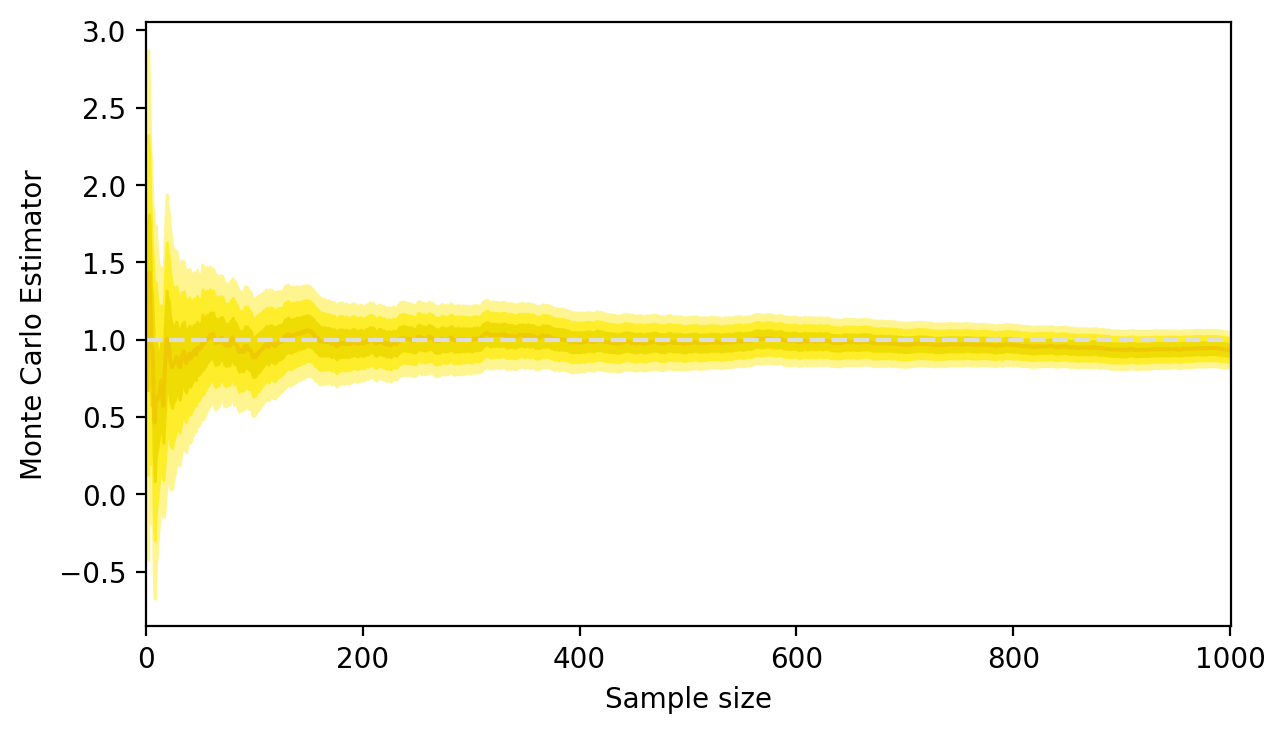

In [3]:
sample_normal = normal(loc=1,scale=1.25,size=1000)
rolling_mean, rolling_mcse = rolling_stats(sample_normal)
fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
ax.plot([1,1000],[1,1],color=LIGHT_GREY,linestyle='--')
plt.show()

## Estimate uncertainity with increasing sample size

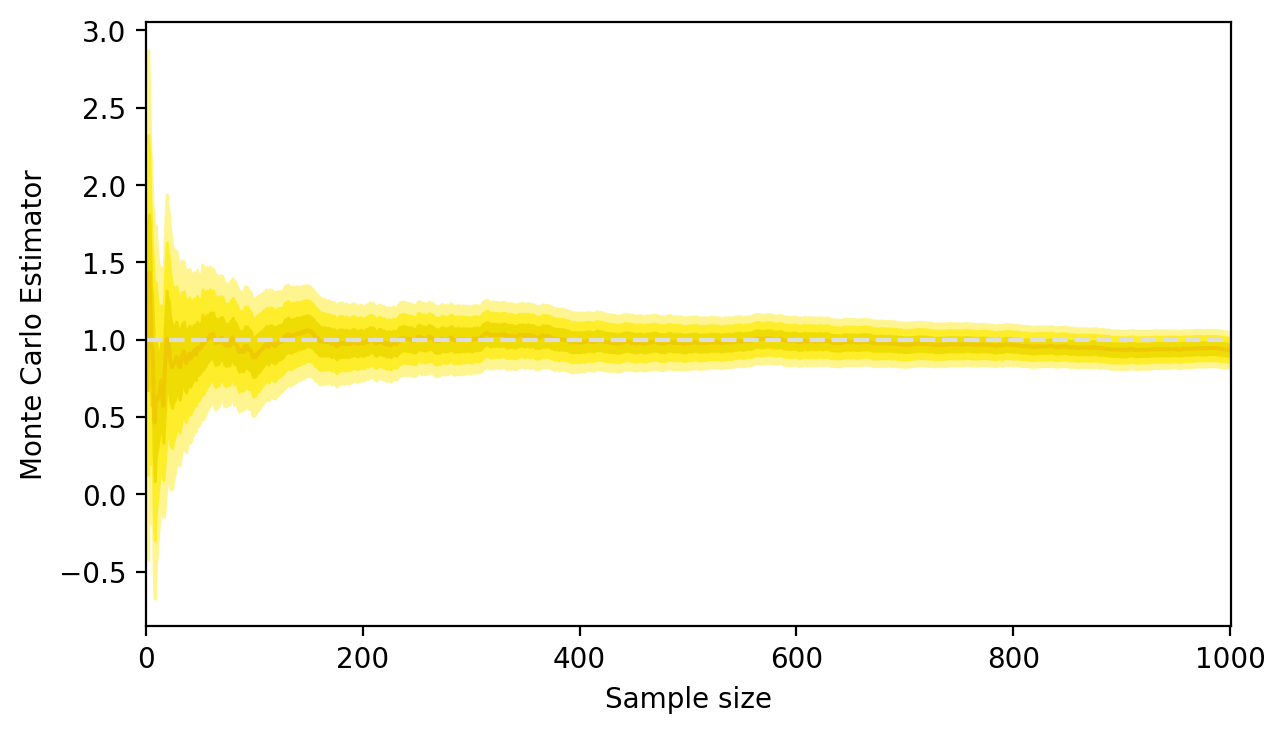

In [4]:
fig

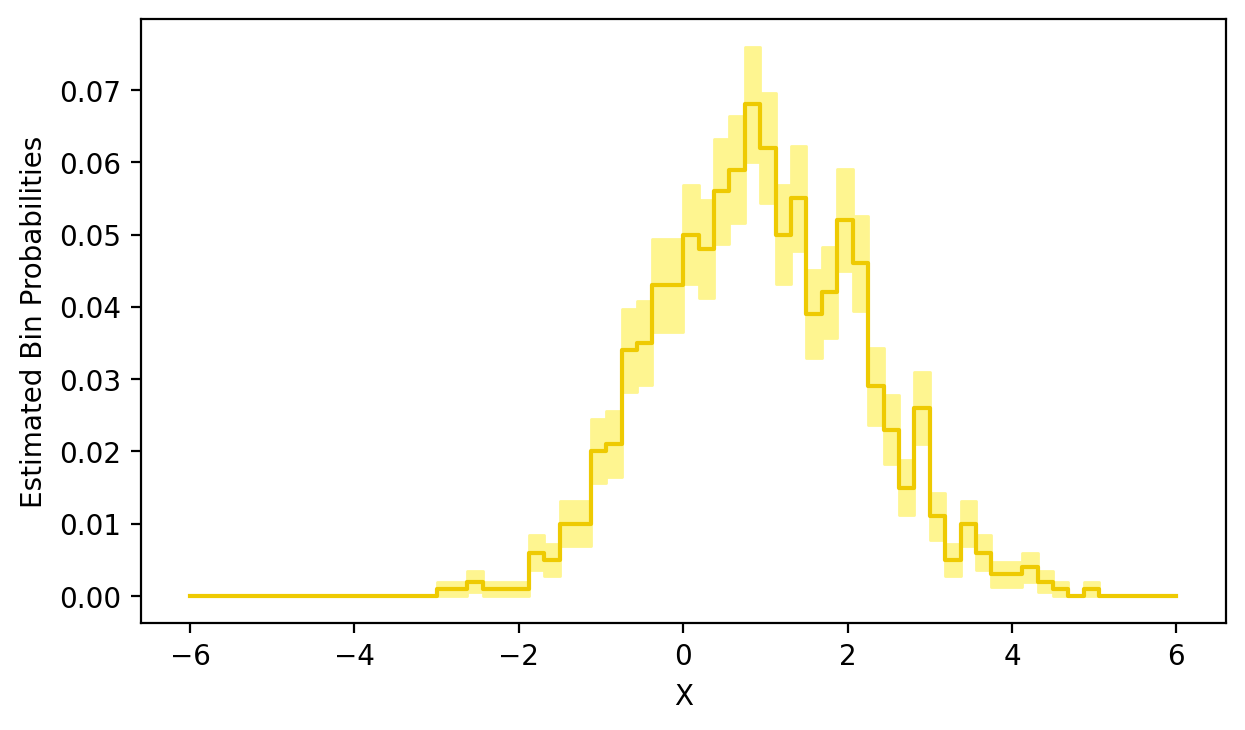

In [5]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax)


## Histogram of the sample 

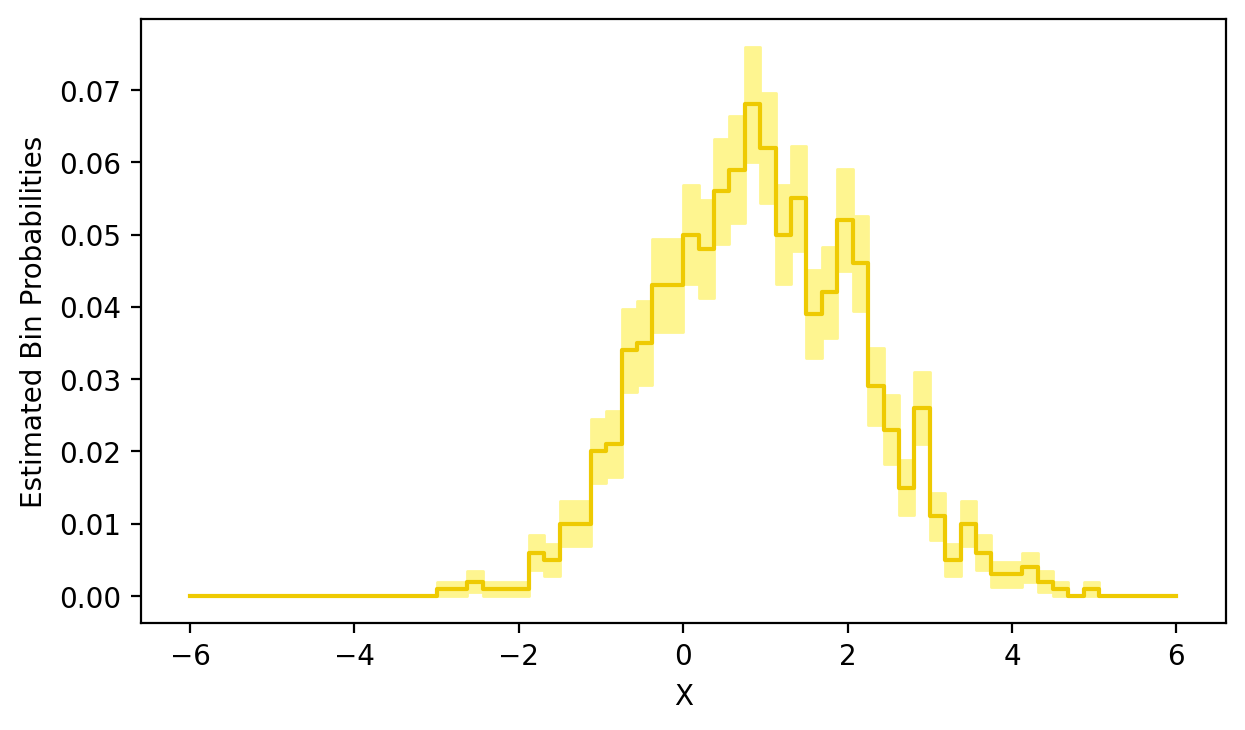

In [6]:
fig

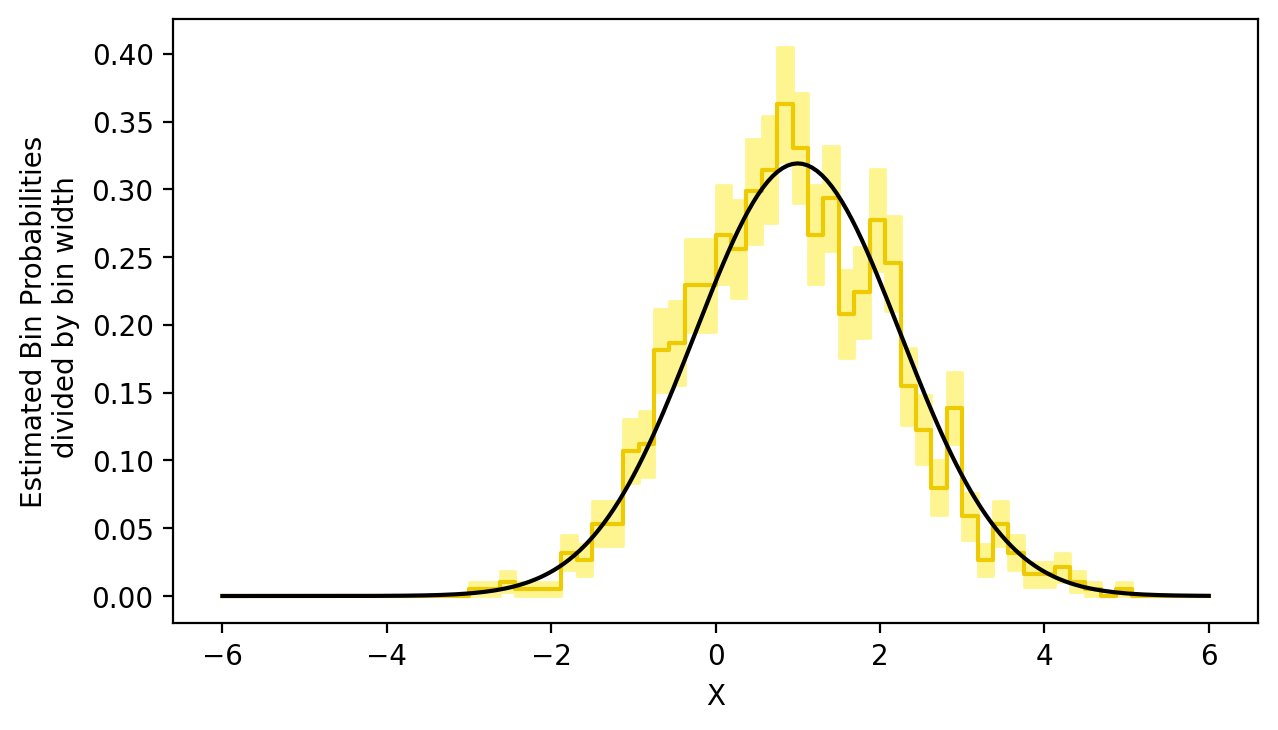

In [7]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,stats.norm.pdf(xs,1,1.25),color='black')

## Comparison with analytical result

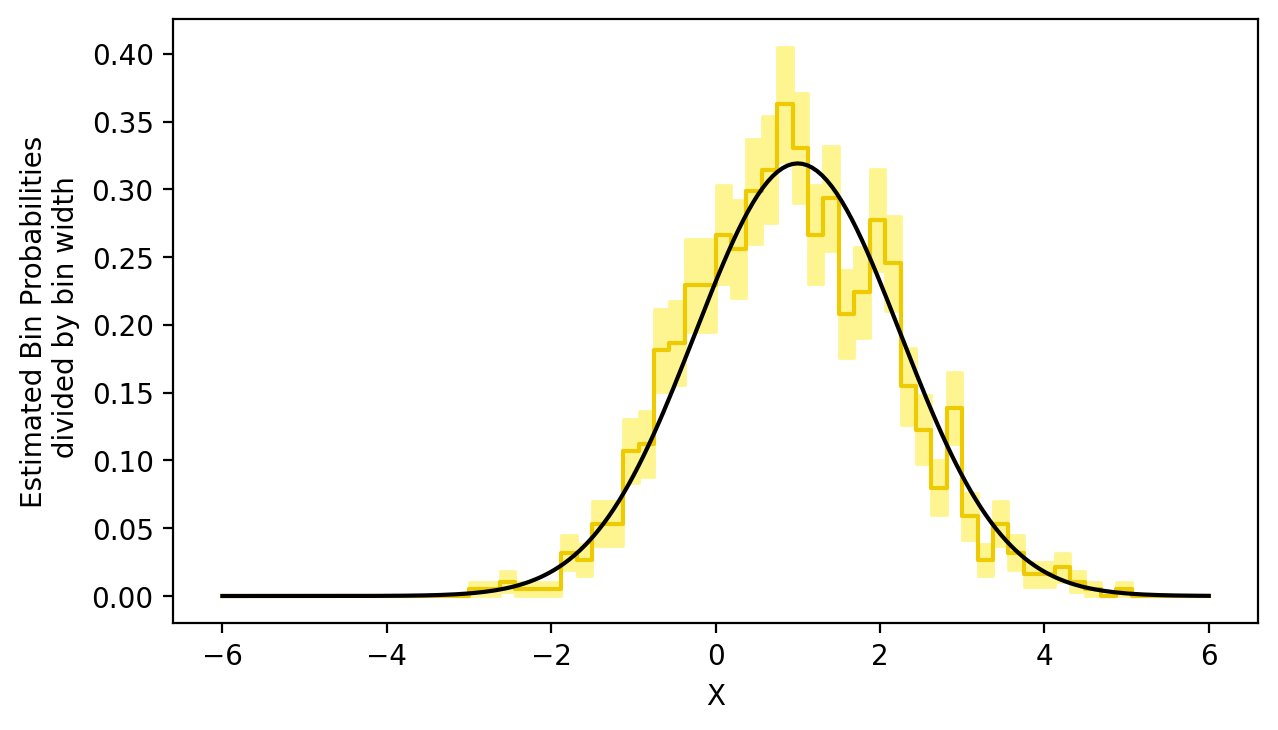

In [8]:
fig

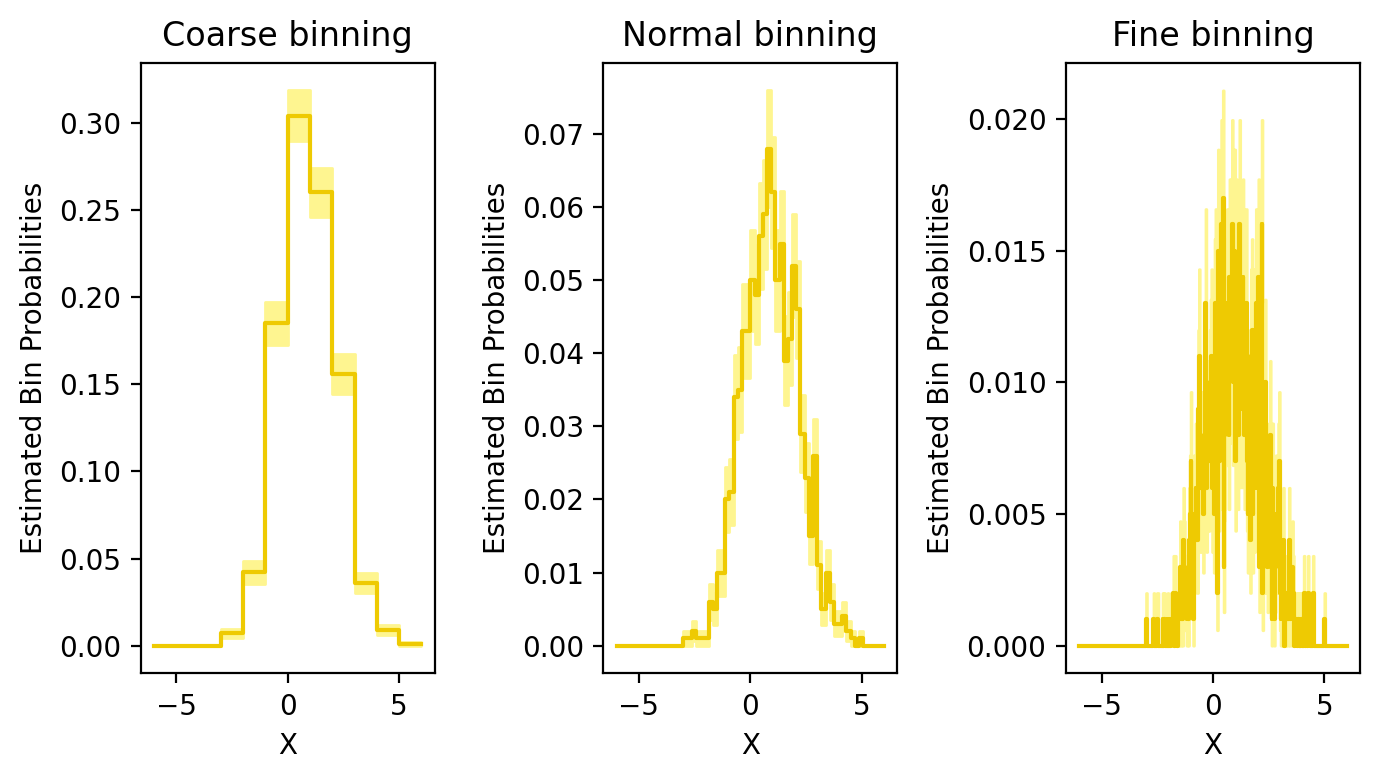

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (7,4),)

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13))
ax1=mc_hist_plot(new_bins, probs,mc_se,ax1)
ax1.set_title('Coarse binning')
new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*5))
ax2=mc_hist_plot(new_bins, probs,mc_se,ax2)
ax2.set_title('Normal binning')

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*25))
ax3=mc_hist_plot(new_bins, probs,mc_se,ax3)
ax3.set_title('Fine binning')

plt.tight_layout()

## Binning makes a difference 

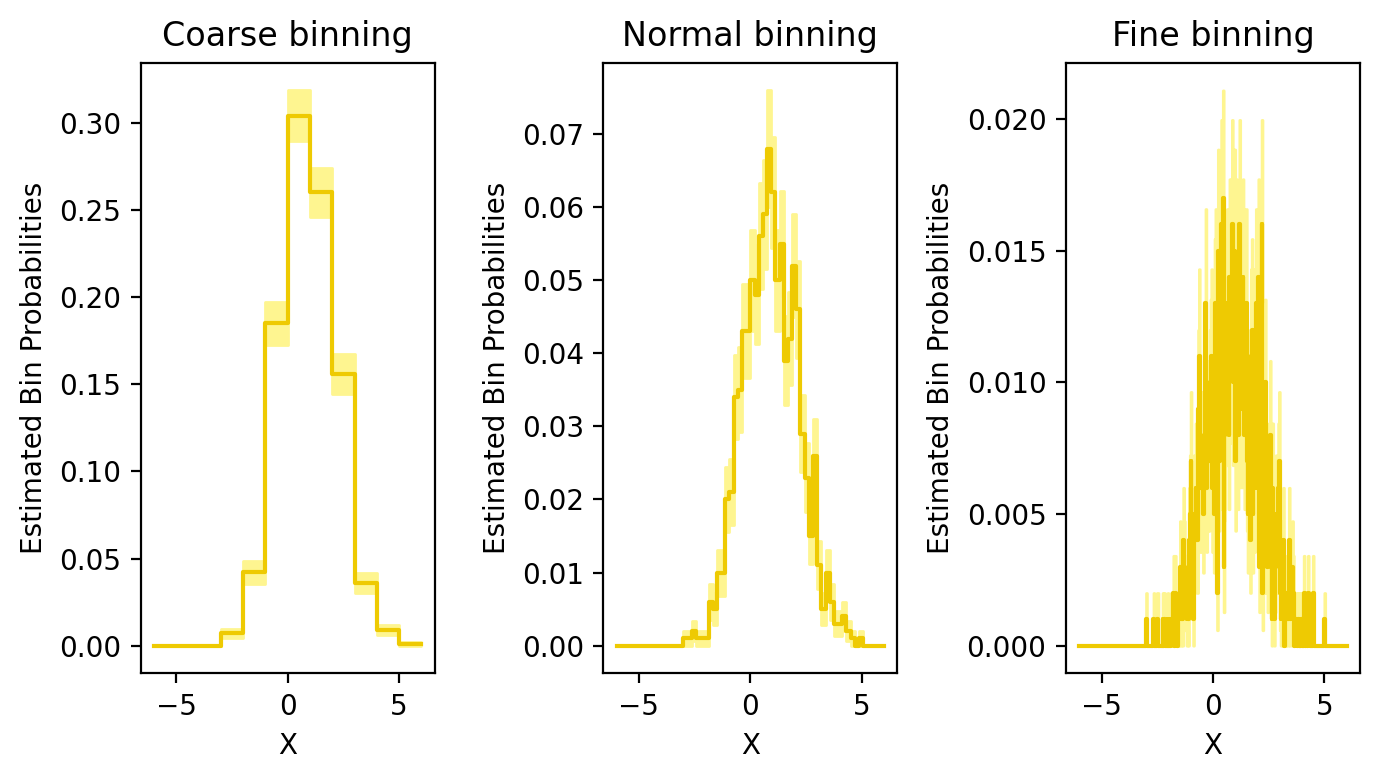

In [10]:
fig

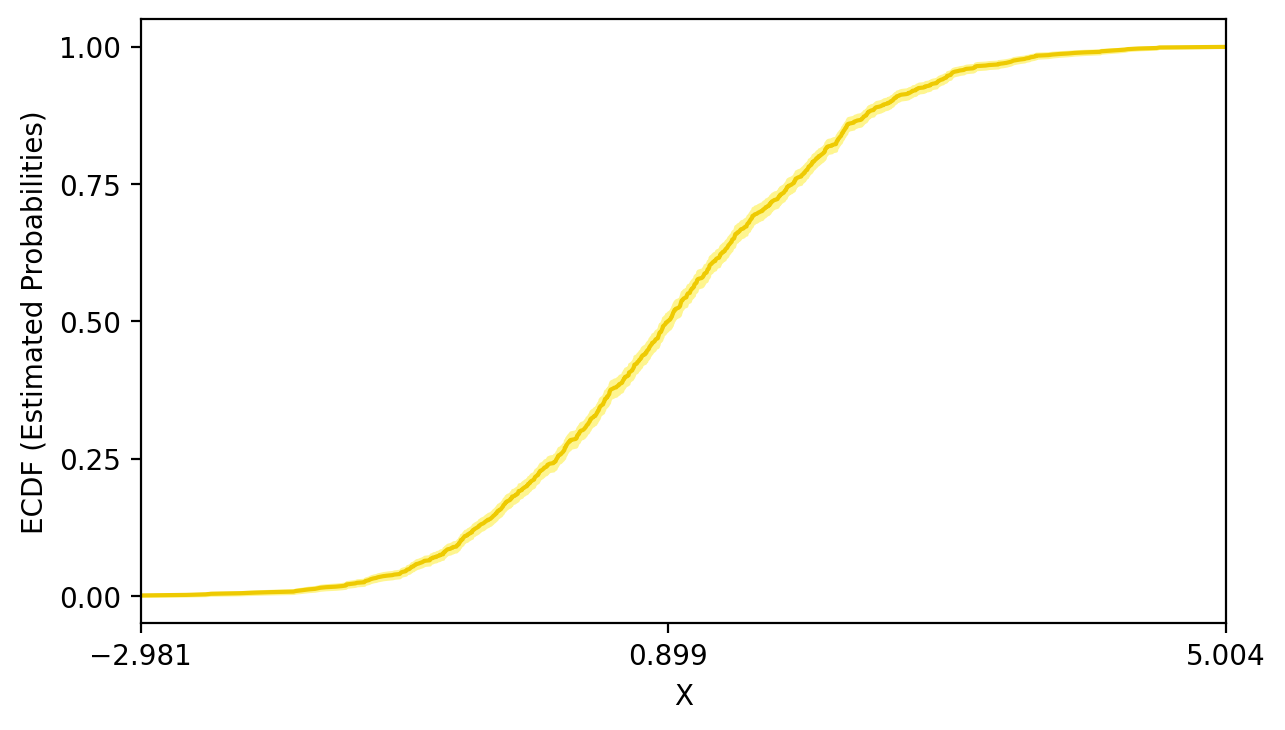

In [11]:
values, probs, mc_se = mc_ecdf(sample_normal)
fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_ecdf_plot(values, probs, mc_se,ax)


## ECDF

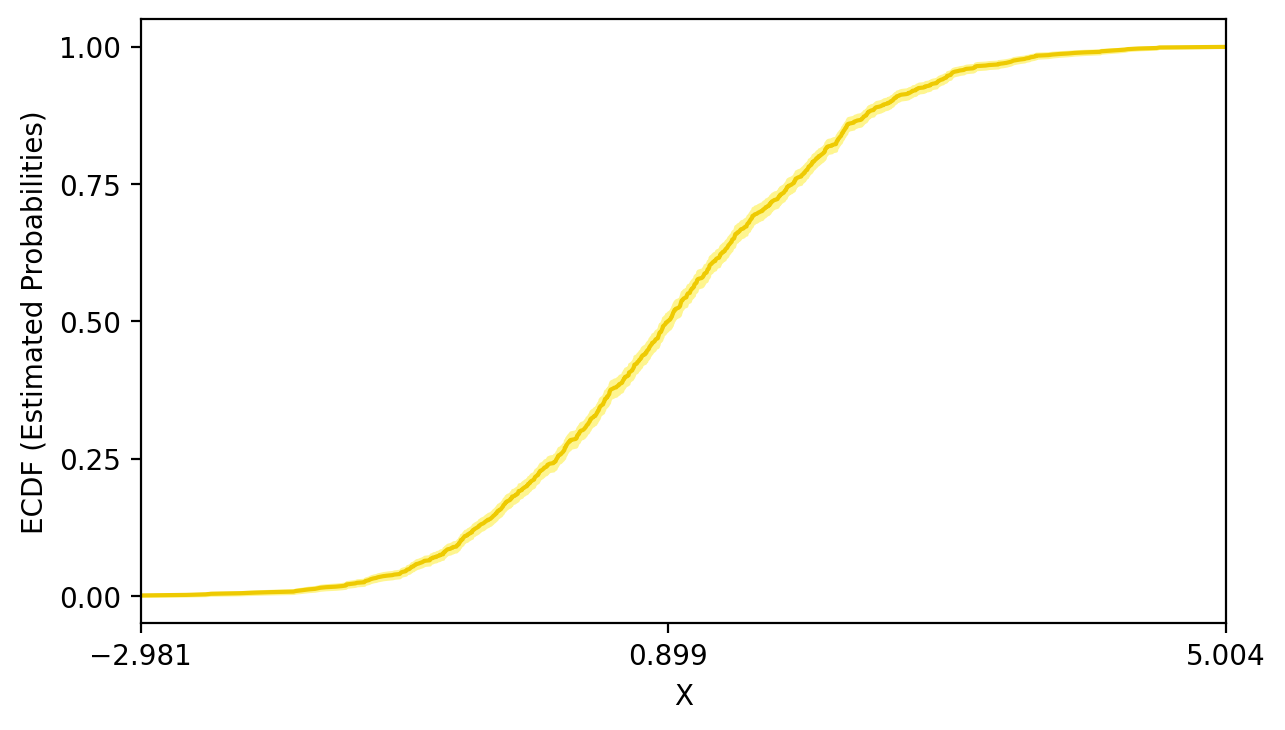

In [12]:
fig

## Example 2 - Normal samples pushed through inverse logistic function

Inverse logit (or expit) function 

$$
\begin{alignat*}{6}
\text{logit}^{-1} :\; &X = \mathbb{R} & &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\frac{1}{1 + \exp(-x)}&.
\end{alignat*}
$$

In python it is readilly available

```python
from scipy.special import expit,logit

```


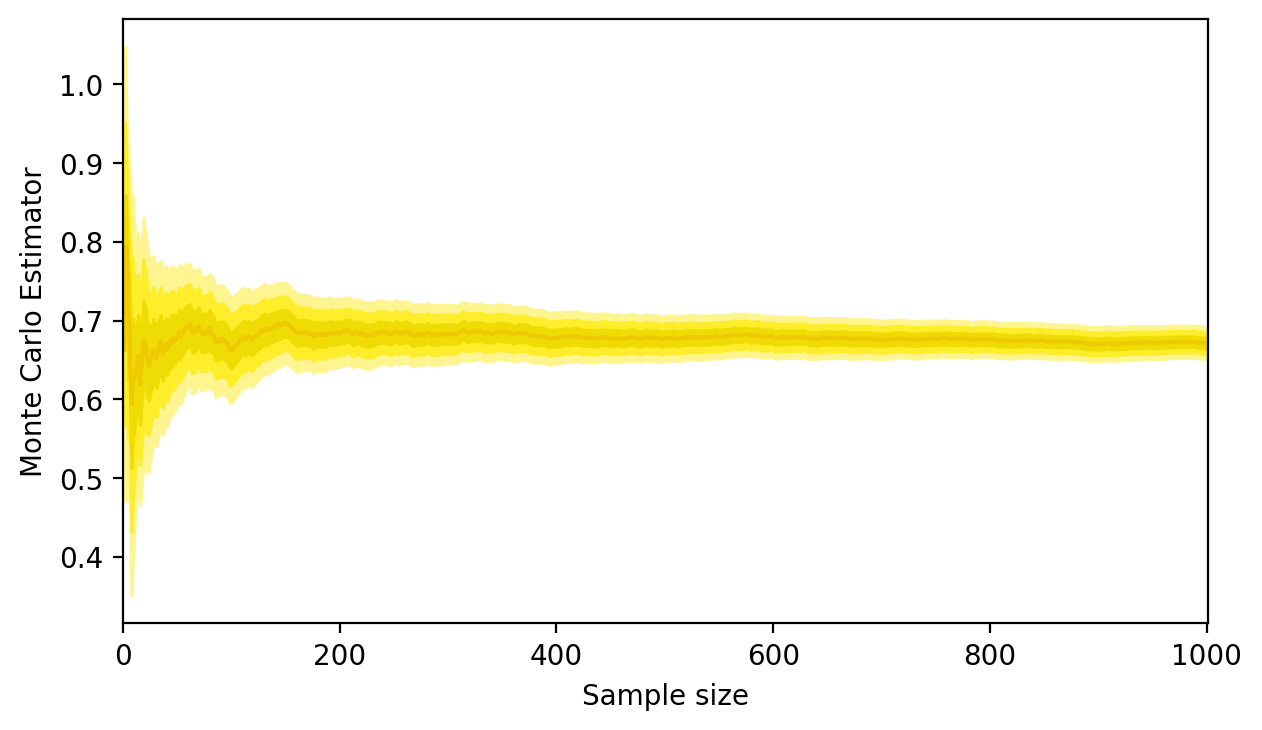

In [13]:
sample_pushforward = expit(sample_normal)
rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Samples are constrained, but expecation converges

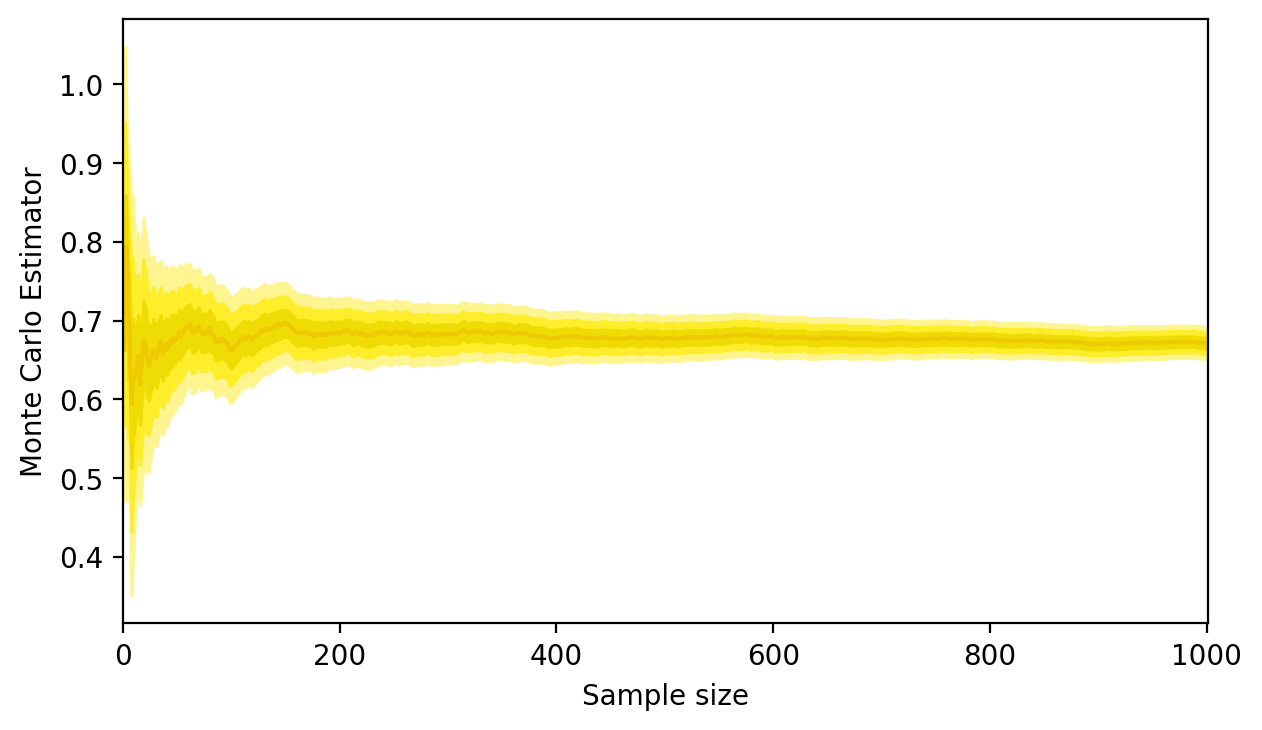

In [14]:
fig

## Histogram allows observation of concentration around expected value

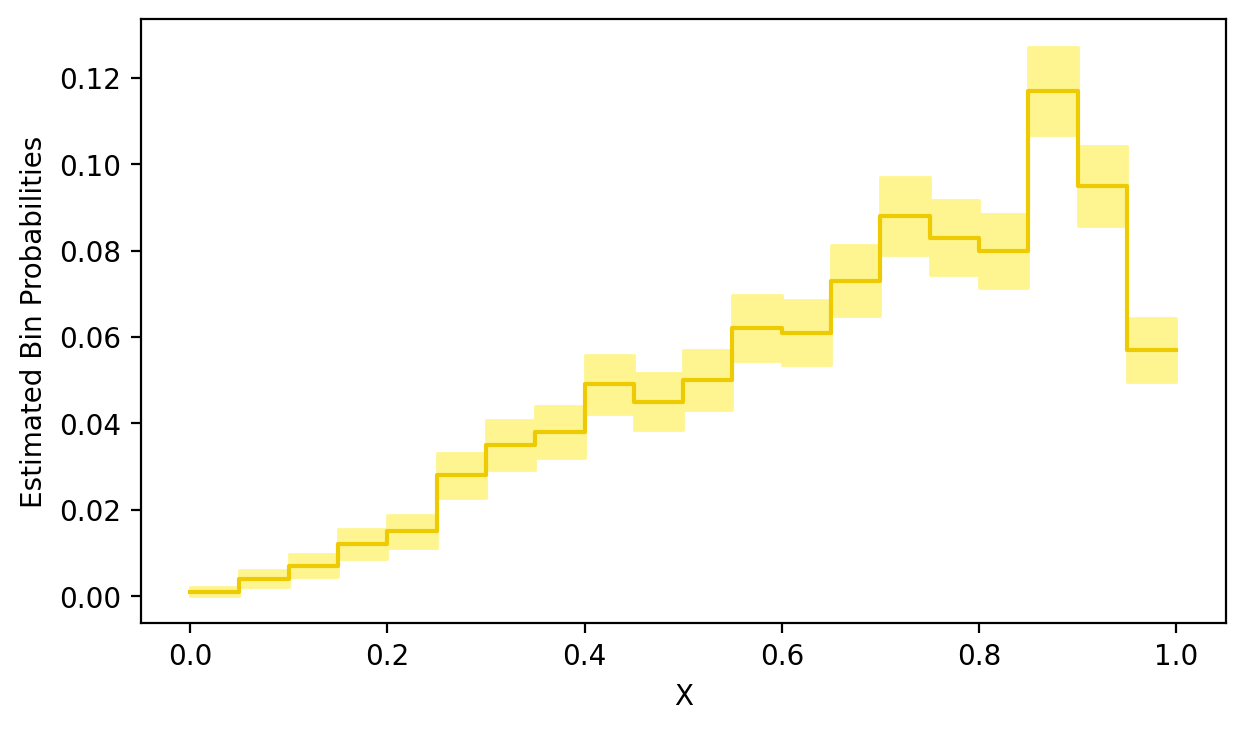

In [15]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=False)



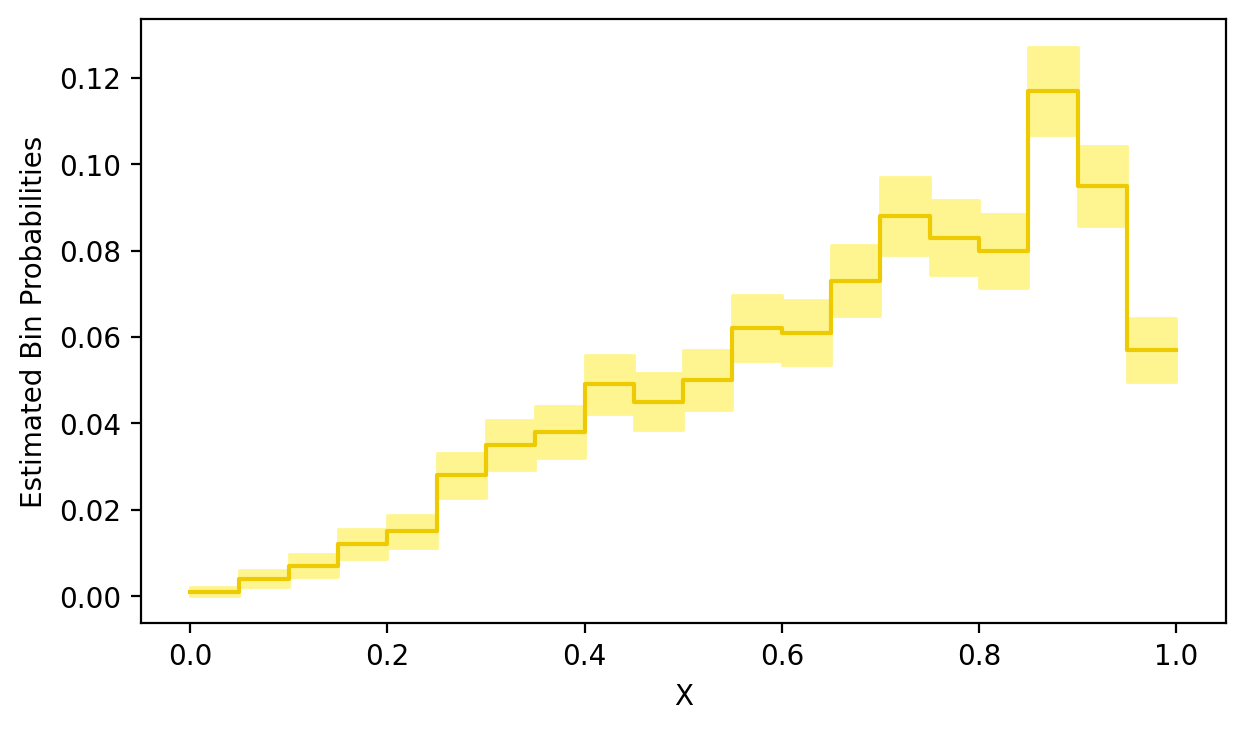

In [16]:
fig

## Changing scale we can compare it with analytical pushforward

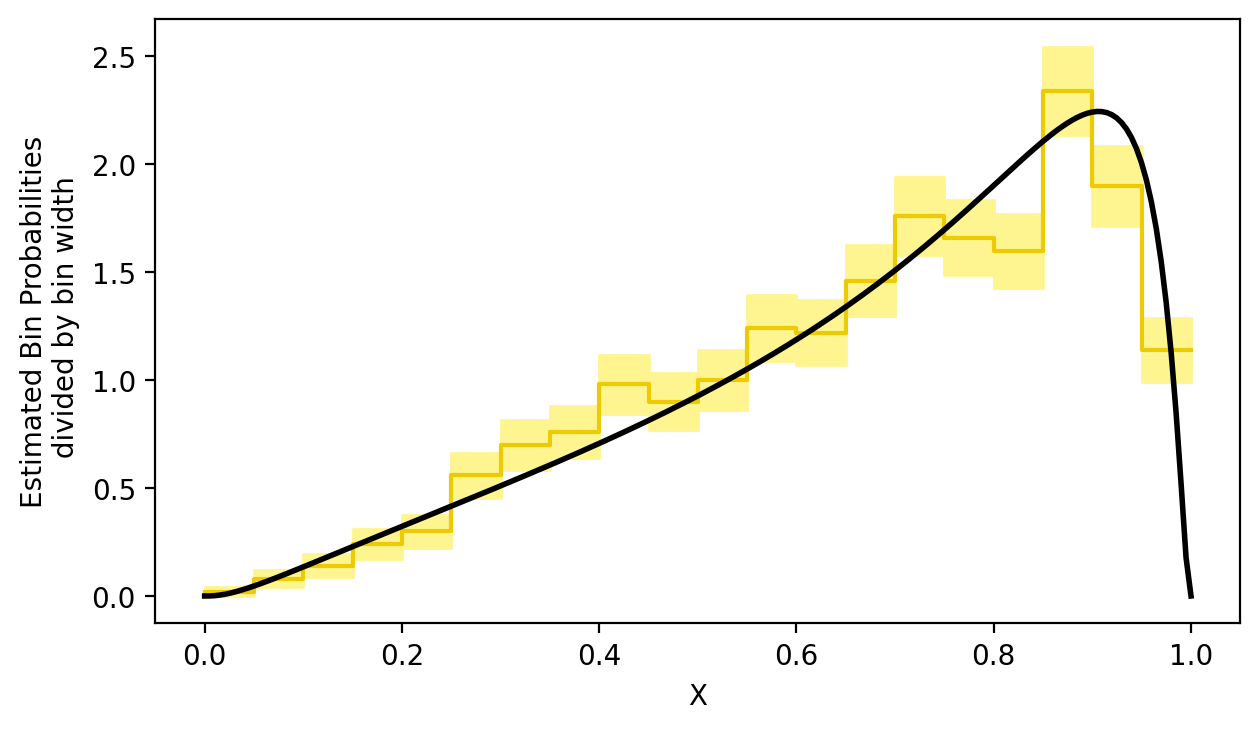

In [18]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig,ax = plt.subplots(1,1,figsize = (7,4))

xs = np.linspace(1e-6,1-1e-6,200)
analytical = stats.norm.pdf(logit(xs),1,1.25)/(xs*(1-xs))
ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,analytical,color='black',linewidth=2)



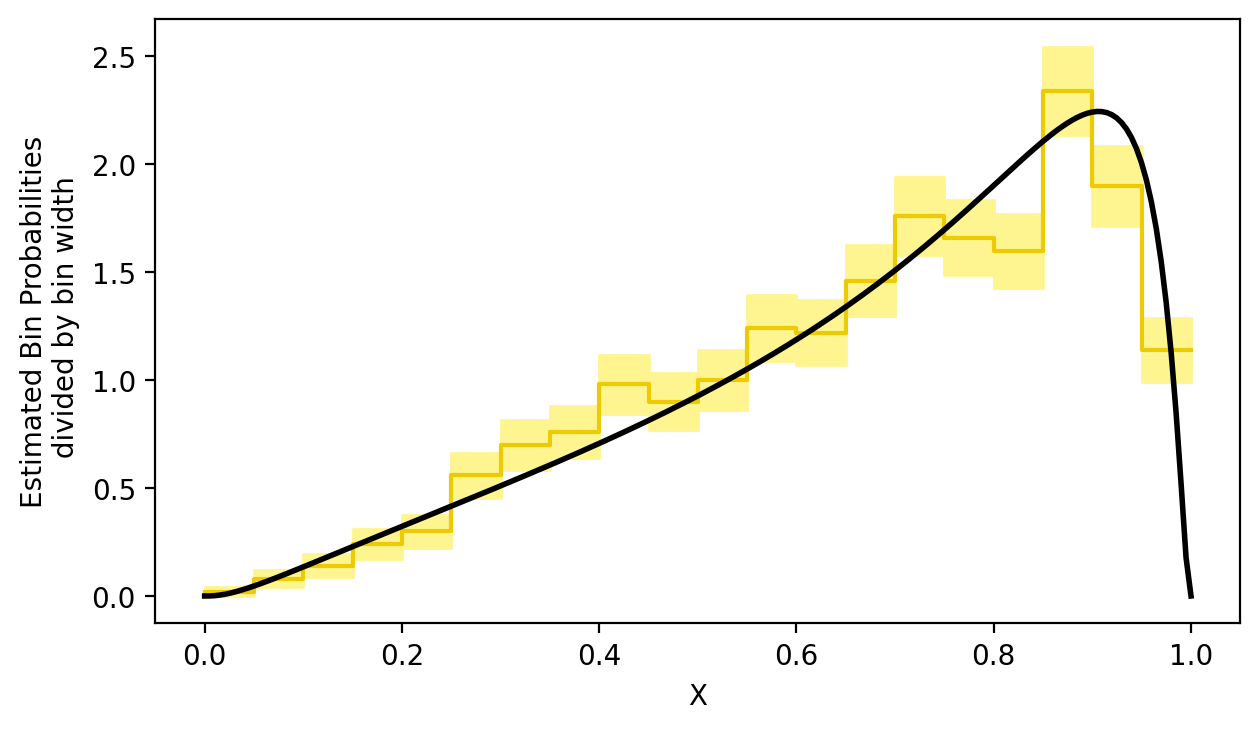

In [19]:
fig

## ECDF for completness

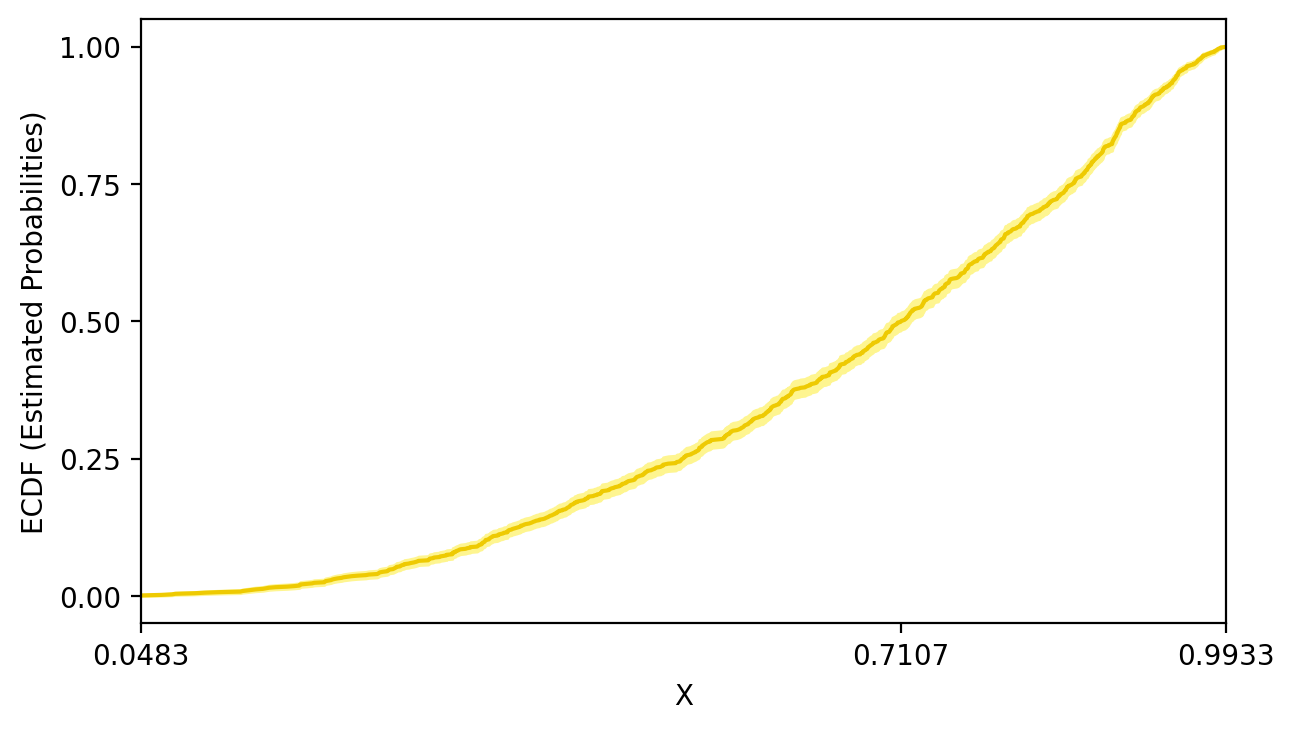

In [20]:
values, probs, mc_se = mc_ecdf(sample_pushforward)

fig,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_ecdf_plot(values, probs, mc_se,ax)
plt.show()

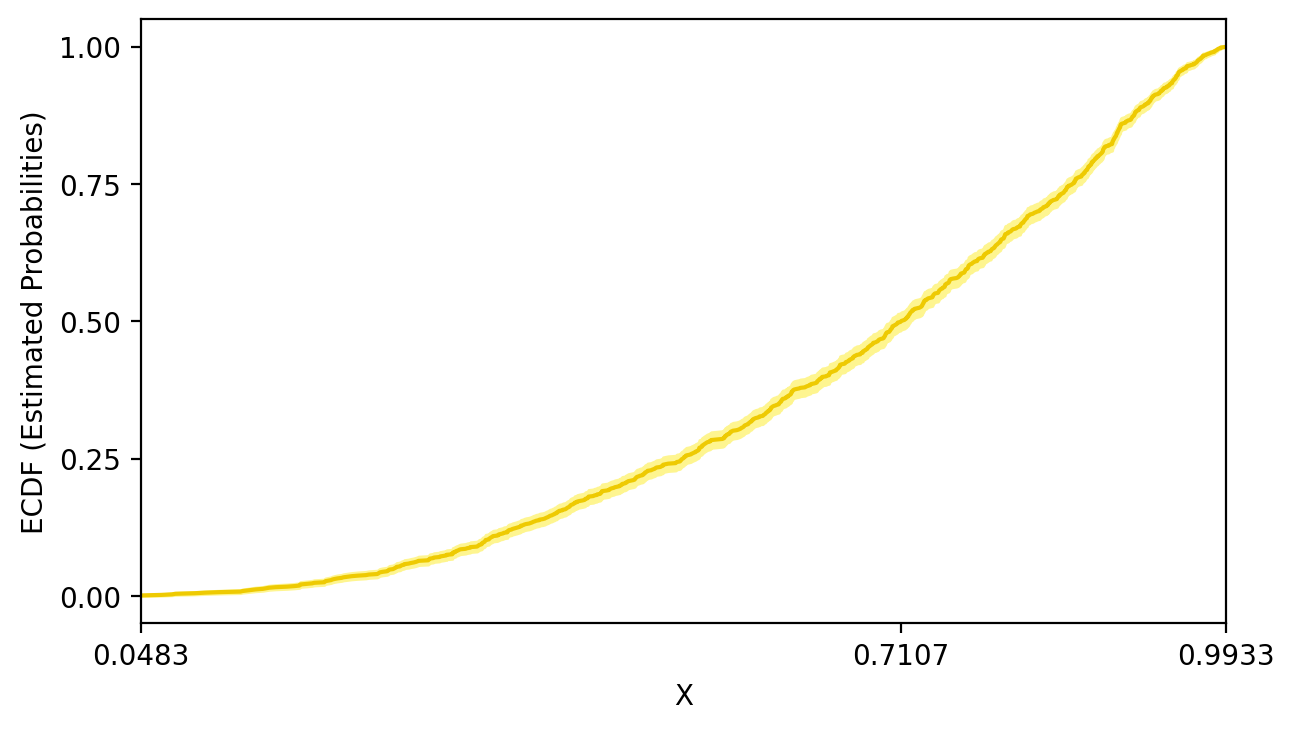

In [21]:
fig

## Example 3 - heavy tailed distribution with undefined mean and variance

In the next series of examples we will be considerning Student's t probability density function,

$$
\pi(x ; \nu) =
\frac{1}{ \sqrt{\pi \, \nu } }
\frac{\Gamma(\frac{\nu + 1}{2})}
{ \Gamma(\frac{\nu}{2}) }
\left(1 + \frac{x^2}{\nu} 
\right)^{- \cfrac{\nu + 1}{2}}.
$$

Its expectation and variance are:

$$
\mathbb{E}_\pi[x] = \begin{cases}
    0& \text{for}\ \nu > 1\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$

$$
\mathbb{V}_\pi[x] = \begin{cases}
    \frac{\nu}{\nu-2}& \text{for}\ \nu > 2\\
    \infty& \text{for}\ \nu (1,2]\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$


Special case for $\nu=1$ is called the Cauchy distribution

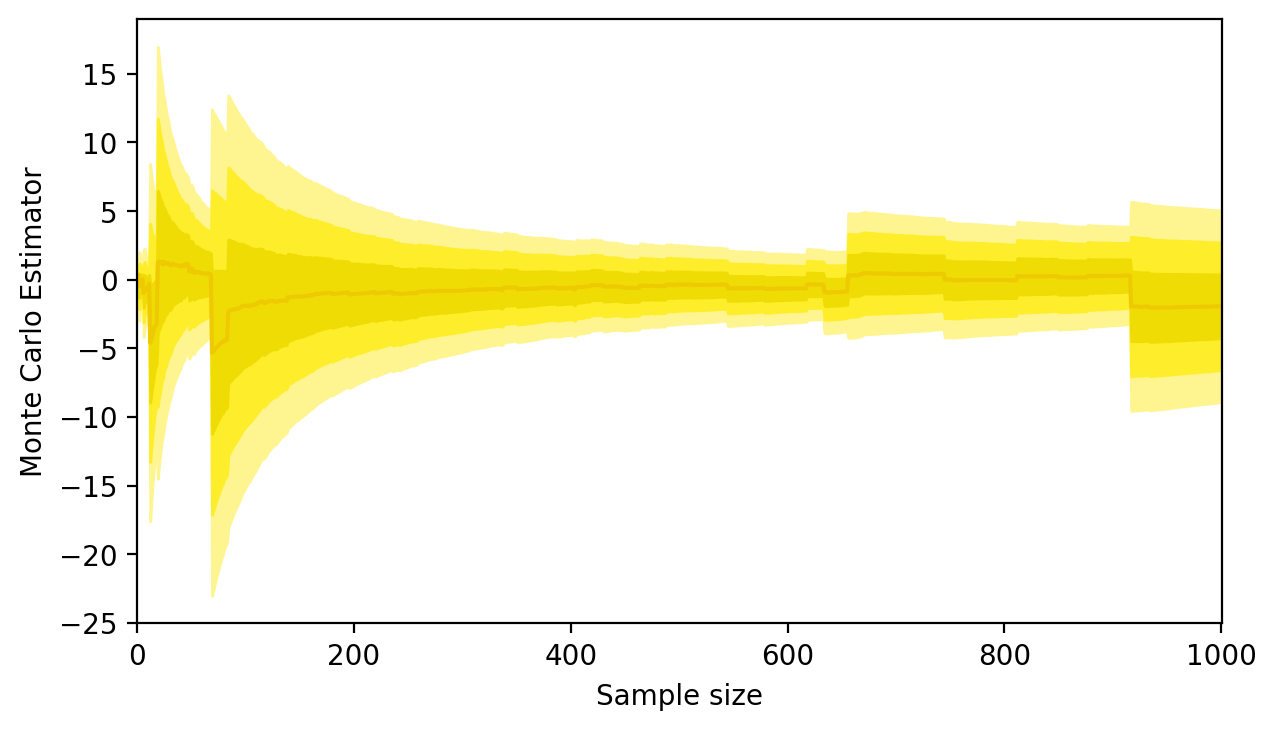

In [22]:
np.random.seed(10052021)
sample_cauchy = standard_t(df = 1,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Expectation of Cauchy samples behaves weirdly

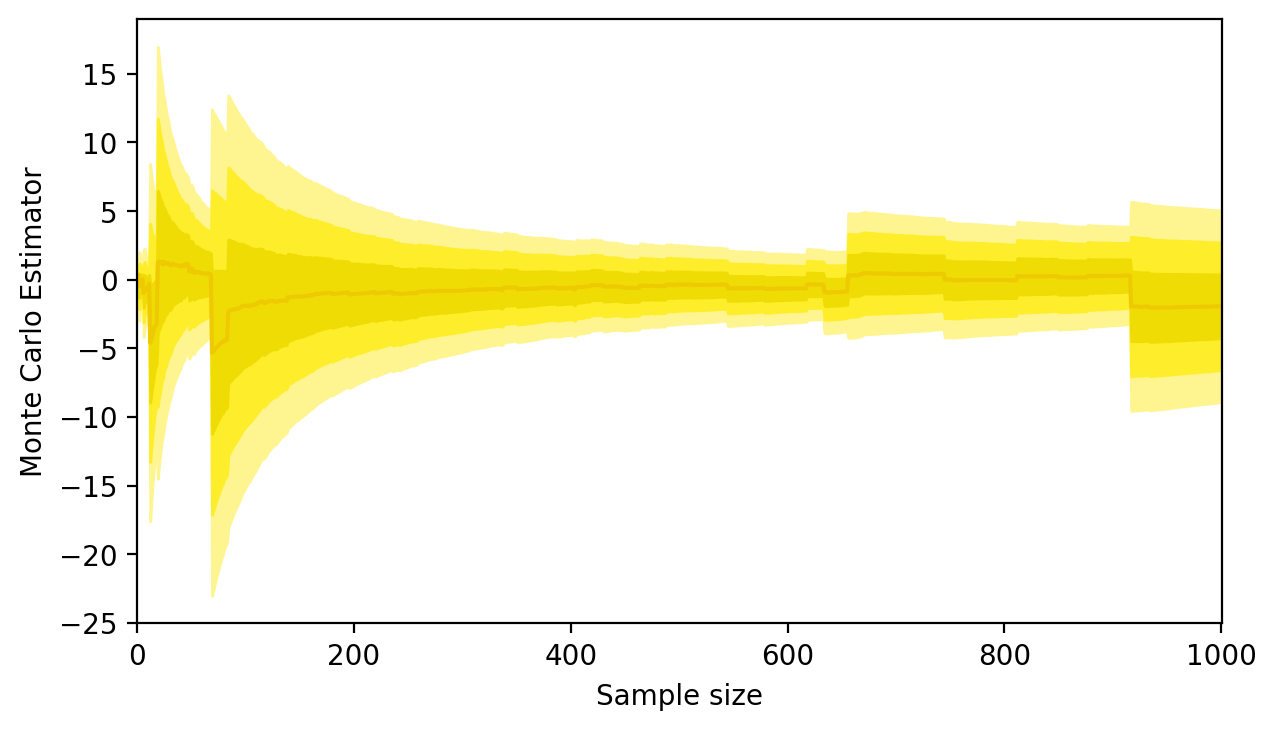

In [23]:
fig

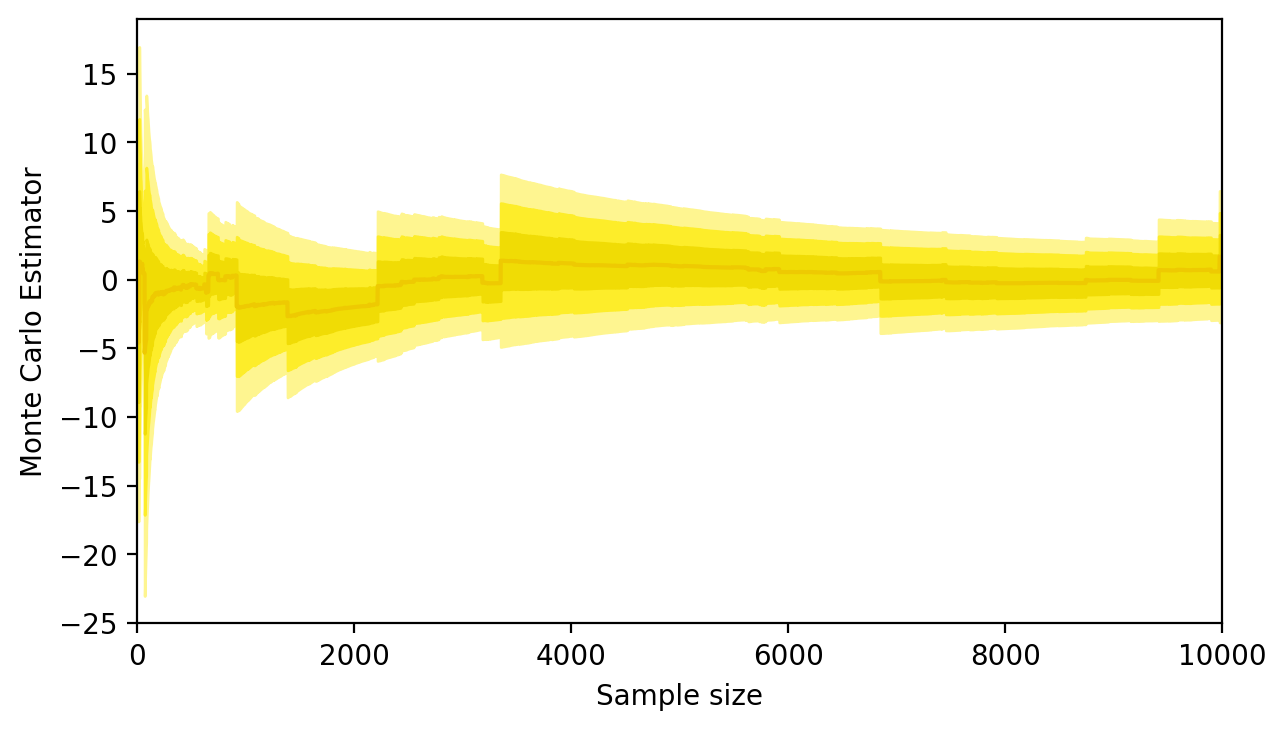

In [24]:
sample_cauchy_long = np.hstack((sample_cauchy,standard_t(df = 1,size = 9000)))


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy_long)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Increase of number of samples does not improve situation

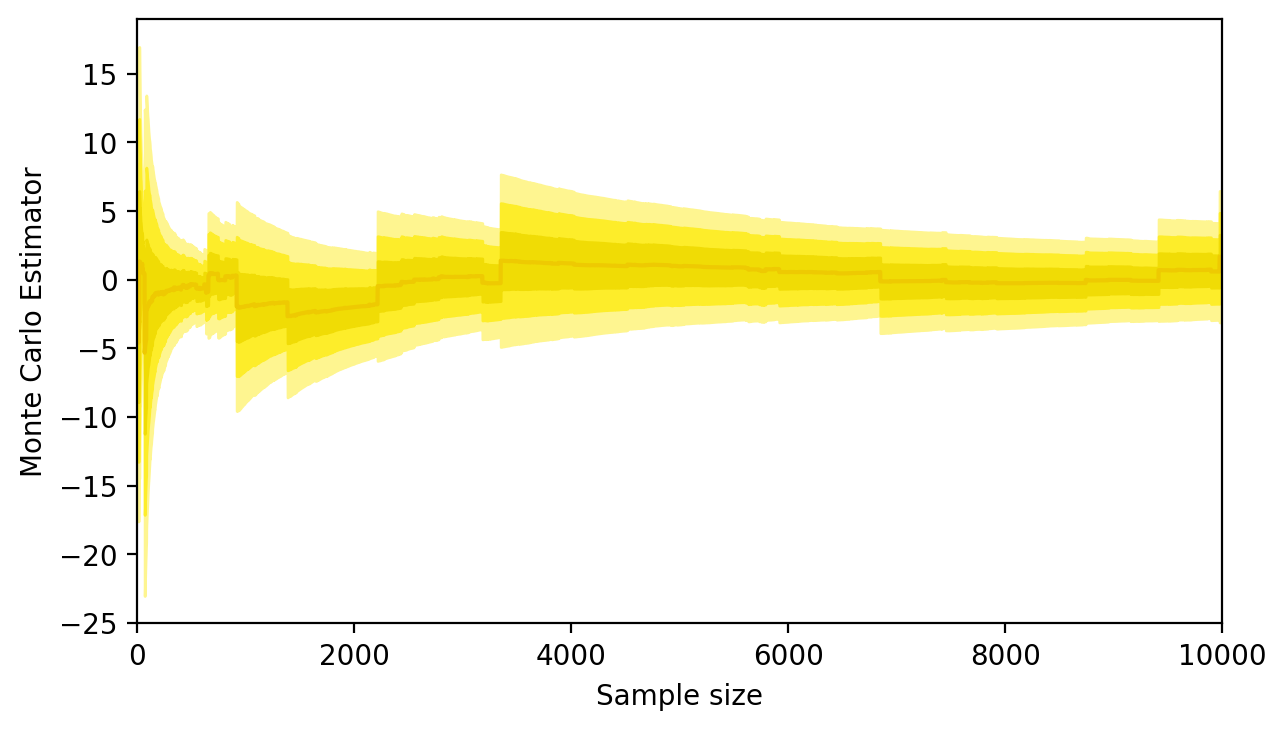

In [25]:
fig

In [26]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))


## Does central limit theorem even hold?

Monte Carlo computation is generally based on Central Limit Theorem. If it holds, then the estimator standarized by the Monte Carlo standard error should be normally distributed around true expectation

$$
\frac{ \hat{f}_{N}^{\text{MC}} - \mathbb{E}_{\pi}[f] }
{\text{MC-SE}_{N}[f] } 
\sim \mathcal{N}(0, 1),
$$
So we can analyze multiple samples and analyze histogram of the estimator

```python
for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))
```



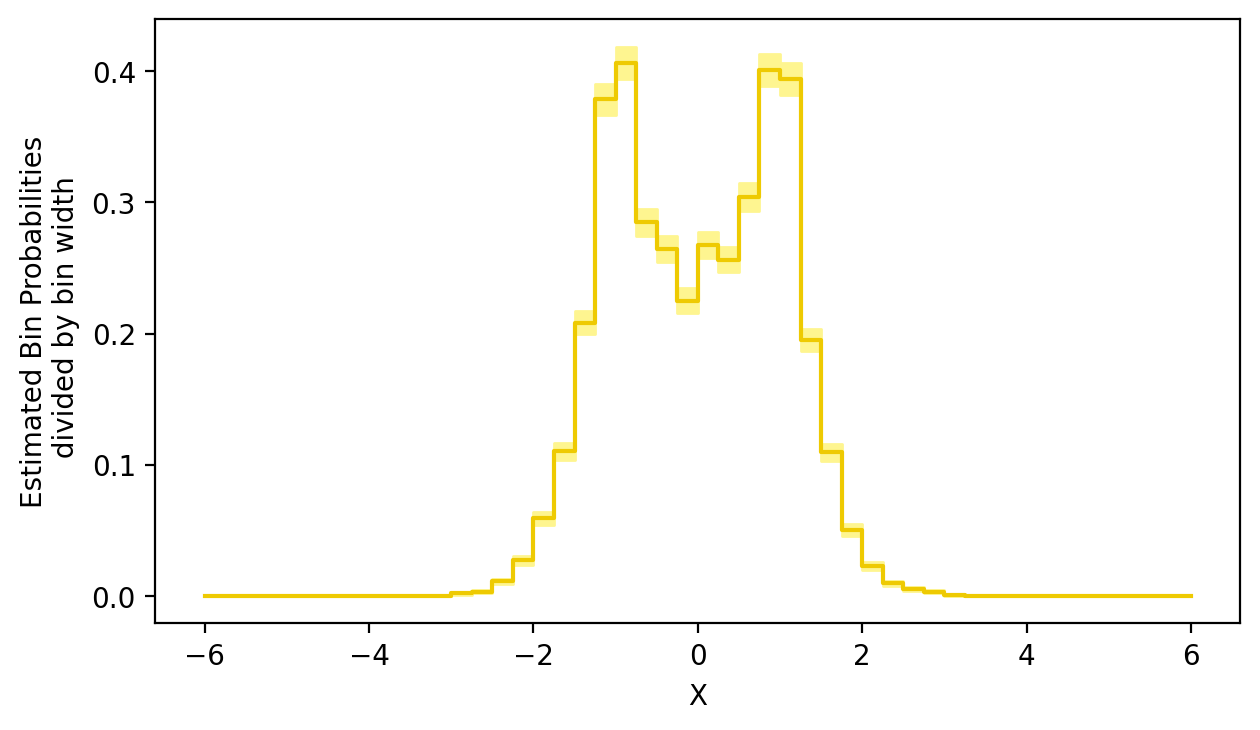

In [27]:
fig,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)

## That's not normal!

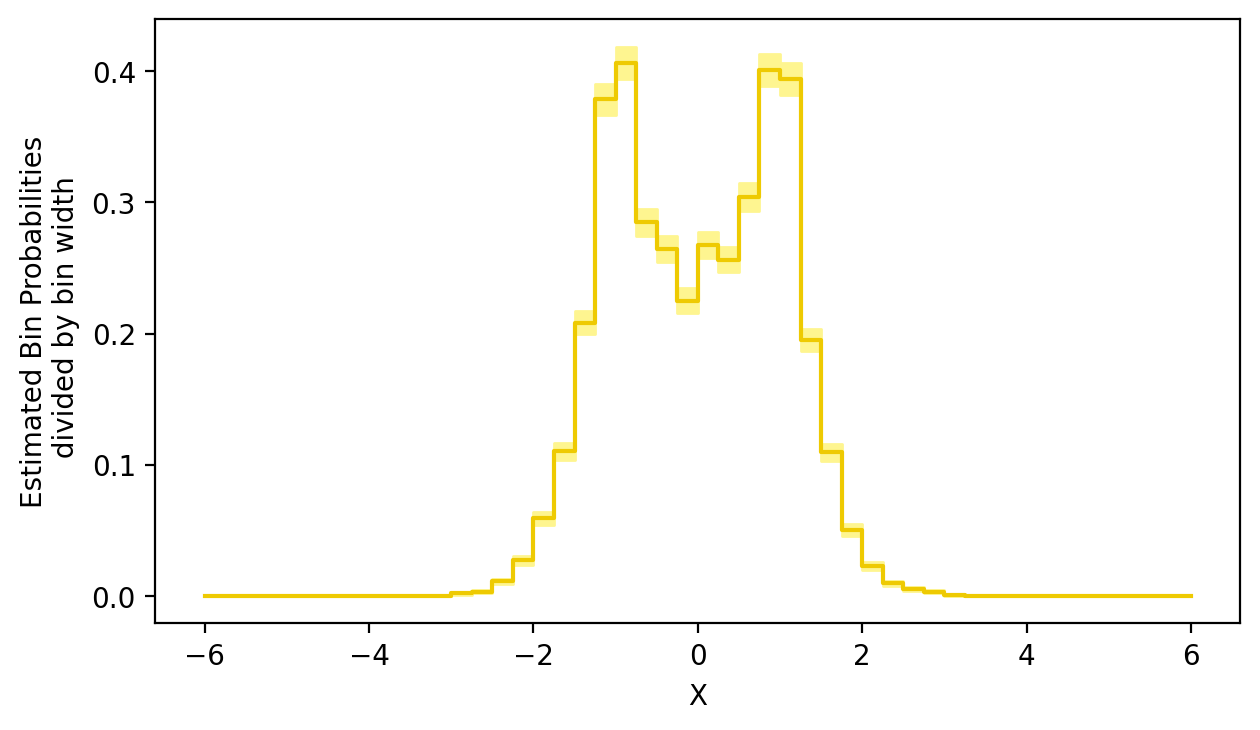

In [28]:
fig

In [ ]:
indicator = lambda x: 1 if (x>-1 and x<0) else 0
sample_pushforward = np.vectorize(indicator)(sample_cauchy)

rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()


In [ ]:
pd.DataFrame({'MC_Est':rolling_mean[-1],'MCSE':rolling_mcse[-1]},index=['Indicator'])


In [ ]:
sample_student_inf_variance = standard_t(df = 1.5,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student_inf_variance)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

In [ ]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1.5,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

In [ ]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)

In [ ]:
sample_student = standard_t(df = 3,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student)

fig,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

In [ ]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 3,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

In [ ]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)

## Quantifying tail behavior

Generalized Pareto distribution

$$
\pi(x) = \begin{cases}
\frac{1}{\sigma}(1 - \frac{k}{\sigma} z)^{\frac{1}{k}-1} & \text{for }k \neq 0, \\
\frac{1}{\sigma}e^{-x/\sigma} & \text{for }k = 0.
\end{cases}
$$

It is a good model for extreme values, in particular it is widely used to determine if samples come from 'heavy tailed' distribution.

## $\hat{k}$ as a test function
We use a point estimator $\hat{k}$ (by Zhang and Stephens) as a check for problems. We fit $\hat{k}$ for tail of each distribution. 

As a rule of thumb: 
- Tails with $\hat{k}>0.7$ it is really problematic
- $\hat{k}$ <0.25 is a sensible threshold 

In [ ]:
from math import floor
def k_hat (x):
    N = len(x)
    x = np.array(sorted(x))
    if x[0]<=0:
        raise ValueError('x must be positive')
    q = x[floor(0.25*N+0.5)-1]
    M = 20 + floor(np.sqrt(N))
    b_hat_vec = np.zeros(M)
    log_w_vec = np.zeros(M)

    for m in range(M):
        b_hat_vec[m] = 1 / x[-1] + (1 - np.sqrt(M / (m + 0.5))) / (3 * q)
        k_hat = - np.mean(np.log(1-b_hat_vec[m]*x))
        log_w_vec[m] = N*(np.log(b_hat_vec[m]/k_hat)+k_hat-1)
    max_log_w = np.max(log_w_vec)
    b_hat = np.sum(b_hat_vec*np.exp(log_w_vec-max_log_w))/np.sum(np.exp(log_w_vec-max_log_w))
    return np.mean(np.log(1-b_hat*x))

In [ ]:
def tail_khats(x):
    x_center = np.median(x)
    if (x_center==np.min(x) or x_center==np.max(x)):
        return (0,0)
    x_left = np.abs(x[x<=x_center]-x_center)
    x_right = x[x>=x_center]-x_center

    return k_hat(x_left),k_hat(x_right)

In [ ]:
tail_khats(sample_student)

index = ['Cauchy - small sample','Cauchy', 'Student-T - nu=1.5', 'Student-T - nu=3','Normal']

samples = [sample_cauchy,sample_cauchy_long,sample_student_inf_variance,sample_student,sample_normal]
left = [tail_khats(x)[0] for x in samples]
right = [tail_khats(x)[1] for x in samples]
khat_summary = pd.DataFrame({'Left Tail khat':left,'Right Tail khat':right},index=index)

In [ ]:
khat_summary

## Main takeaways

- Monte Carlo sampling, as long as distribution is well posed offers valuable estimates and error quantification
- Any probability estimate has its own error
- If samples are not consistent or distribution lacks necessary moments issues can happen
- There are possible diagnostics of tail behavior that can lead to useful guidelines
- Multidimensional sampling requires more tools -> MCMC 


## Extra reading

Much more about sampling and further examples and deeper theory can be found in [Rumble in the ensemble](https://betanalpha.github.io/assets/case_studies/sampling.html) by Michael Betancourt